In [3]:
# Knowledge Distillation for 7-Class Image Classification
# Combines directory-based data loading and custom CNN/augmentation from Teacher_model.ipynb

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
# -------------------------------
# 0) Reproducibility
# -------------------------------
SEED = 42
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)



In [8]:
# -------------------------------
# 1) Configuration
# -------------------------------
img_size = 128
batch_size = 16
num_classes = 7
input_shape = (img_size, img_size, 3)

train_path = "C:/Users/SATARUPA/OneDrive/Desktop/Tiny ML/Hydrophobicity Classes Photos/train"
val_path = "C:/Users/SATARUPA/OneDrive/Desktop/Tiny ML/Hydrophobicity Classes Photos/validation"

In [9]:
# -------------------------------
# 2) Data Generators
# -------------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=SEED,
)
val_data = val_datagen.flow_from_directory(
    val_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=SEED,
)


Found 2800 images belonging to 7 classes.
Found 700 images belonging to 7 classes.


In [ ]:
# -------------------------------
# 3) Custom CNN (as in Teacher_model.ipynb)
# -------------------------------
def custom_cnn(x):
    # Block 1
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    #x = layers.Dropout(0.25)(x)

    # Block 2
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    #x = layers.Dropout(0.3)(x)

    # Block 3
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    #x = layers.Dropout(0.4)(x)

    # Block 4
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    #x = layers.Dropout(0.5)(x)

    x = layers.GlobalAveragePooling2D()(x)
    return x



In [11]:
def build_teacher(input_shape=(128, 128, 3), num_classes=7):
    inputs = Input(shape=input_shape)
    x = custom_cnn(inputs)  # custom CNN block for feature extraction
    x = layers.Dense(64, activation='relu')(x)
    #x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inputs, outputs, name="teacher")

def build_student(input_shape=(128, 128, 3), num_classes=7):
    inputs = Input(shape=input_shape)
    # Smaller or lighter custom CNN block or fewer filters inside if desired
    x = custom_cnn(inputs)
    x = layers.Dense(32, activation='relu')(x)  # fewer units than teacher
    #x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inputs, outputs, name="student")

# Then create models like this:
teacher = build_teacher()
student_baseline = build_student()
student_for_kd = build_student()

In [12]:
# -------------------------------
# 5) Callbacks (as in your Teacher_model.ipynb)
# -------------------------------
checkpoint = callbacks.ModelCheckpoint(
    "model_teacher_kd.keras", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)
lr_reducer = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)
early_stop = callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True, verbose=1)


In [13]:
# -------------------------------
# 6) Train TEACHER
# -------------------------------
teacher.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)
print("\n[1/4] Training TEACHER...")
hist_teacher = teacher.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[early_stop, checkpoint, lr_reducer],
    verbose=2,
)


[1/4] Training TEACHER...
Epoch 1/20

Epoch 1: val_accuracy improved from -inf to 0.14286, saving model to model_teacher_kd.keras
175/175 - 80s - loss: 0.9970 - accuracy: 0.6029 - val_loss: 10.1246 - val_accuracy: 0.1429 - lr: 0.0010 - 80s/epoch - 457ms/step
Epoch 2/20

Epoch 2: val_accuracy did not improve from 0.14286
175/175 - 19s - loss: 0.7798 - accuracy: 0.6943 - val_loss: 8.2311 - val_accuracy: 0.1429 - lr: 0.0010 - 19s/epoch - 109ms/step
Epoch 3/20

Epoch 3: val_accuracy improved from 0.14286 to 0.62571, saving model to model_teacher_kd.keras
175/175 - 19s - loss: 0.6834 - accuracy: 0.7329 - val_loss: 1.0624 - val_accuracy: 0.6257 - lr: 0.0010 - 19s/epoch - 109ms/step
Epoch 4/20

Epoch 4: val_accuracy did not improve from 0.62571
175/175 - 18s - loss: 0.6106 - accuracy: 0.7586 - val_loss: 1.7181 - val_accuracy: 0.5329 - lr: 0.0010 - 18s/epoch - 105ms/step
Epoch 5/20

Epoch 5: val_accuracy did not improve from 0.62571
175/175 - 19s - loss: 0.4892 - accuracy: 0.8093 - val_loss: 

In [14]:
# Save teacher model
teacher.save("C:/Users/SATARUPA/OneDrive/Desktop/Tiny ML/teacher_model.keras")


In [15]:
import os

# Path to the saved teacher model file
model_path = "model_teacher_kd.keras"

# Get the size of the file in bytes
file_size_bytes = os.path.getsize(model_path)

# Convert size to kilobytes (KB)
file_size_kb = file_size_bytes / 1024

# Convert size to megabytes (MB)
file_size_mb = file_size_kb / 1024

print(f"Model size: {file_size_bytes} bytes")
print(f"Model size: {file_size_kb:.2f} KB")
print(f"Model size: {file_size_mb:.2f} MB")


Model size: 14473936 bytes
Model size: 14134.70 KB
Model size: 13.80 MB


In [ ]:
# -------------------------------
# 7) Train BASELINE STUDENT (no KD)
# -------------------------------
student_baseline.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)
print("\n[2/4] Training STUDENT (baseline, no KD)...")
hist_baseline = student_baseline.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[early_stop, lr_reducer],
    verbose=2,
)

In [ ]:
# Save student baseline model
student_baseline.save("C:/Users/SATARUPA/OneDrive/Desktop/Tiny ML/student_baseline_model.keras")

In [ ]:
# -------------------------------
# 8) KD STUDENT via Distiller (probability-based temperature, categorical)
# -------------------------------
def temp_scale_probs(p, T, eps=1e-8):
    # p: (batch, num_classes) probabilities
    p = tf.clip_by_value(p, eps, 1.0)
    pT = tf.pow(p, 1.0 / T)
    pT = pT / tf.reduce_sum(pT, axis=-1, keepdims=True)
    return pT

class Distiller(Model):
    def __init__(self, student, teacher, T=2.0, alpha=0.7):
        super().__init__(name="distiller_softmax")
        self.student = student
        self.teacher = teacher
        self.teacher.trainable = False
        self.T = float(T)
        self.alpha = float(alpha)
        self.ce = keras.losses.CategoricalCrossentropy()
        self.kld = keras.losses.KLDivergence()
        self.acc = keras.metrics.CategoricalAccuracy(name="acc")
        self.hard_tracker = keras.metrics.Mean(name="hard_loss")
        self.soft_tracker = keras.metrics.Mean(name="soft_loss")
        self.kd_tracker = keras.metrics.Mean(name="kd_loss")

    @property
    def metrics(self):
        return [self.acc, self.hard_tracker, self.soft_tracker, self.kd_tracker]

    def train_step(self, data):
        x, y = data

        t_probs = self.teacher(x, training=False)
        with tf.GradientTape() as tape:
            s_probs = self.student(x, training=True)
            hard = self.ce(y, s_probs)
            t_T = temp_scale_probs(t_probs, self.T)
            s_T = temp_scale_probs(s_probs, self.T)
            soft = self.kld(t_T, s_T)
            kd_total = self.alpha * hard + (1.0 - self.alpha) * (self.T ** 2) * soft
        grads = tape.gradient(kd_total, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.student.trainable_variables))
        self.acc.update_state(y, s_probs)
        self.hard_tracker.update_state(hard)
        self.soft_tracker.update_state(soft)
        self.kd_tracker.update_state(kd_total)
        return {"loss": kd_total, "acc": self.acc.result(),
                "hard_loss": self.hard_tracker.result(),
                "soft_loss": self.soft_tracker.result(),
                "kd_loss": self.kd_tracker.result()}

    def test_step(self, data):
        x, y = data
        s_probs = self.student(x, training=False)
        loss = self.ce(y, s_probs)
        self.acc.update_state(y, s_probs)
        return {"loss": loss, "acc": self.acc.result()}


In [ ]:
alpha_values = [0.7]
T_values = list(range(9, 11))

results = {}
for alpha in alpha_values:
    final_train_losses = []
    final_val_losses = []
    final_train_accuracies = []
    final_val_accuracies = []
    final_hard_losses = []
    final_soft_losses = []
    final_kd_losses = []
    for T in T_values:
        print(f"Training with alpha={alpha}, T={T}")
        distiller = Distiller(student=student_for_kd, teacher=teacher, T=T, alpha=alpha)
        distiller.compile(optimizer='adam')
        hist_kd = distiller.fit(
            train_data,
            validation_data=val_data,
            epochs=30,
            callbacks=[early_stop, lr_reducer],
            verbose=0
        )
        final_train_losses.append(hist_kd.history['loss'][-1])              # Only last epoch's train loss
        final_val_losses.append(hist_kd.history['val_loss'][-1])            # Only last epoch's val loss
        final_train_accuracies.append(hist_kd.history['acc'][-1])      # Only last epoch's train accuracy
        final_val_accuracies.append(hist_kd.history['val_acc'][-1])    # Only last epoch's val accuracy
        final_hard_losses.append(hist_kd.history['hard_loss'][-1])       # Train hard loss (CE)
        final_soft_losses.append(hist_kd.history['soft_loss'][-1])       # Train soft loss (KL-div)
        final_kd_losses.append(hist_kd.history['kd_loss'][-1])
        print(
            f"Last train_loss: {hist_kd.history['loss'][-1]:.4f}, train_acc: {hist_kd.history['acc'][-1]:.4f}, "
            f"val_loss: {hist_kd.history['val_loss'][-1]:.4f}, val_acc: {hist_kd.history['val_acc'][-1]:.4f}, "
            f"hard_loss: {hist_kd.history['hard_loss'][-1]:.4f}, soft_loss: {hist_kd.history['soft_loss'][-1]:.4f}, kd_loss: {hist_kd.history['kd_loss'][-1]:.4f}"
)   

    results[alpha] = {
        'T': T_values,
        'train_loss': final_train_losses,
        'train_acc': final_train_accuracies,
        'val_loss': final_val_losses,
        'val_acc': final_val_accuracies,
        'hard_loss': final_hard_losses,
        'soft_loss': final_soft_losses,
        'kd_loss': final_kd_losses
    }


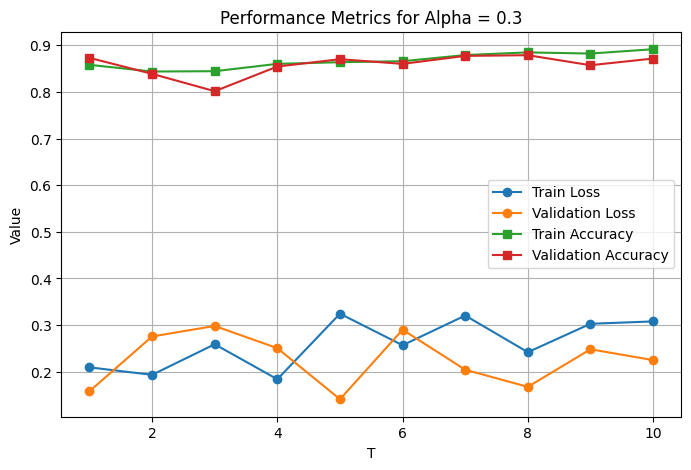

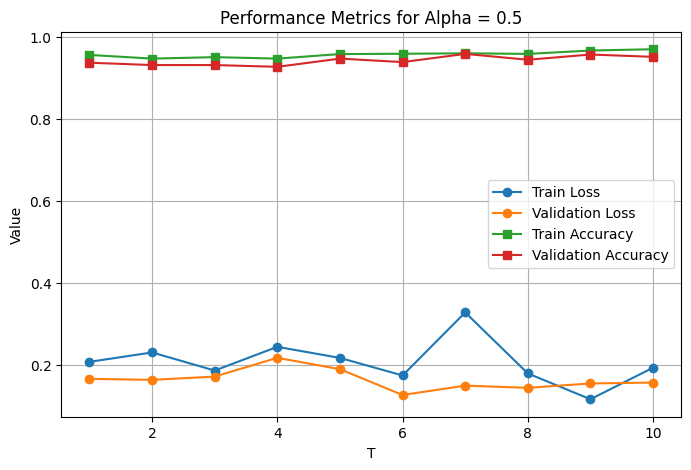

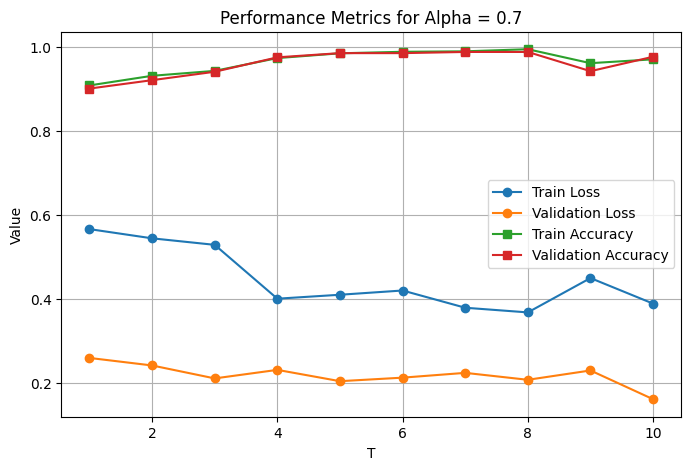

In [22]:

import pandas as pd
import matplotlib.pyplot as plt

# Load your CSV file
file_path = "alpha-T-LastTrainLoss-TrainAccuracy-LastValLoss-ValAccuracy.csv"
df = pd.read_csv(file_path)

# Get unique alpha values
unique_alpha = df["alpha"].unique()

# Plot for each alpha
for a in unique_alpha:
    subset = df[df["alpha"] == a]

    plt.figure(figsize=(8, 5))
    plt.plot(subset["T"], subset["Last Train Loss"], label="Train Loss", marker="o")
    plt.plot(subset["T"], subset["Last Val Loss"], label="Validation Loss", marker="o")
    plt.plot(subset["T"], subset["Train Accuracy"], label="Train Accuracy", marker="s")
    plt.plot(subset["T"], subset["Val Accuracy"], label="Validation Accuracy", marker="s")
    
    plt.xlabel("T")
    plt.ylabel("Value")
    plt.title(f"Performance Metrics for Alpha = {a}")
    plt.legend()
    plt.grid(True)
    plt.show()



In [5]:
import pandas as pd

# Load your merged csv file
df = pd.read_csv('alpha-T-LastTrainLoss-TrainAccuracy-LastValLoss-ValAccuracy.csv')  # Change the filename as needed

# Calculate the ratio for each row
df['acc_loss_ratio'] = df['Val Accuracy'] / df['Last Val Loss']

# Print all ratios for each alpha and T
# for _, row in df.iterrows():
#     print(f"Alpha = {row['alpha']}, T = {row['T']}: Val Accuracy/Val Loss = {row['acc_loss_ratio']:.4f}")

# For each alpha, get the top 3 T values ranked by the ratio
result = {}
for alpha, group in df.groupby('alpha'):
    top3 = group.nlargest(3, 'acc_loss_ratio')
    result[alpha] = list(top3['T'])

# Print the results
for alpha, t_list in result.items():
    print(f"Alpha {alpha}: Top 3 T values are {t_list}")



Alpha 0.3: Top 3 T values are [5, 1, 8]
Alpha 0.5: Top 3 T values are [6, 8, 7]
Alpha 0.7: Top 3 T values are [10, 5, 8]
